# 1 Image Processing<a id='1_processing'></a>

## 1.1 Contents<a id='1.1_Contents'></a>
* [1 Image Processing](#1_processing)
  * [1.1 Contents](#1.1_Contents)
  * [1.2 Introduction](#1.2_Introduction)
  * [1.3 Imports](#1.3_Imports)
  * [1.4 Extract Images](#1.4_extract)
  * [1.5 Augmentation](#1.5_Augmentation)
  * [1.6 Chunking Data](#1.6_Chunking)  
  * [1.7 Create Evaluation Set](#1.7_eval_set)  
  * [1.8 Display Example Images](#1.8_examples) 

## 1.2 Introduction<a id='1.2_Introduction'></a>

This is the beginning of a project to train a deep neural network to classify oak leaves and maple leaves. The data for the model are original images taken by cell phone video camera. Images are extracted from the videos. The images are further processed -- three augmentations for each image -- by cropping, rotating, and flipping.

The final images are stored in separate directories (maple and oak) for later model training and testing.

## 1.3 Imports<a id='1.3_Imports'></a>

In [1]:
import cv2
import os
import pandas as pd
import numpy as np
from skimage import color
from skimage.transform import rotate, rescale, resize
from pathlib import Path

%matplotlib inline
import matplotlib.pyplot as plt

## 1.4 Extract Images<a id='1.4_extract'></a>

The function extract_frames takes video input and converts it to images in jpg format. 

In [2]:
# credit to
# Hayden Faulkner
# https://medium.com/@haydenfaulkner/extracting-frames-fast-from-a-video-using-opencv-and-python-73b9b7dc9661

def extract_frames(video_path, frames_dir, overwrite=False, start=-1, end=-1, every=1):
    
    video_path = os.path.normpath(video_path)  # make the paths OS (Windows) compatible
    frames_dir = os.path.normpath(frames_dir) 

    video_dir, video_filename = os.path.split(video_path)  # split into path and filename

    assert os.path.exists(video_path)  # for debugging

    capture = cv2.VideoCapture(video_path)  # open video with OpenCV

    if start < 0:  # if start isn't specified, make half a second in
        start = 15
    if end < 0:  # if end isn't specified, make the very end 
        end = int(capture.get(cv2.CAP_PROP_FRAME_COUNT))

    capture.set(1, start)  # set the starting frame of the capture
    frame = start  # frame keeps track with video. initialize to start.
    while_safety = 0  # a safety counter to avoid an infinite while loop
    saved_count = 0  # a count of how many frames saved

    while frame < end:  # loop through the frames until the end

        _, image = capture.read()  # read an image from the capture

        if while_safety > 500:  # break out if safety exceeds 500 (see below)
            break

        # sometimes OpenCV reads None's during a video, in which case we want to skip
        if image is None:  # the image we read is None, don't save
            while_safety += 1  # add 1 to safety count
            continue  # skip to next frame

        if frame % every == 0:  # extract every nth frame
            while_safety = 0  # frame is read, reset the safety count
            name_root = video_filename.split('.')[0] # take name of video from filename
            save_path = os.path.join(frames_dir, name_root + '_{}.jpg'.format(frame))   # name frame with video name and frame number
             
            if not os.path.exists(save_path) or overwrite:  # if file doesn't exist or overwrite allowed
                cv2.imwrite(save_path, image)  # save the extracted frame
                saved_count += 1  # increment our counter by one

        frame += 1  # increment frame count

    capture.release()  # close the capture

    return saved_count  # return the count of the images saved

In [3]:
# assign root to find videos
# should be '' for training set and 'holdout_set/' for testing
root = ''
# save files as list
videos = os.listdir(root + 'videos')

In [4]:
videos

['maple_5.mp4', 'oak_6.mp4']

In [17]:
process_videos = True # stop cell below from running if not needed
if process_videos:
    for video in videos: # loop through each video
        if 'maple' in video: # put frame in the correct folder (by tree)
            folder = 'maple'
        else:
            folder = 'oak'
        video_path = root + 'videos/' + video  # path of video to extract from
        frames_dir = root + 'raw_frames/' + folder  # path of folder to put frames

        # run extract_frames on each video
        extract_frames(video_path, frames_dir, overwrite=False, start=-1, end=-1, every=30)
   

## 1.5 Augmentation<a id='1.5_Augmentation'></a>

In [6]:
pic = os.listdir('raw_frames/oak')[12]
pic

'oak_6_450.jpg'

In [7]:
path = root + 'raw_frames/'+'oak/' + pic

In [8]:
image = plt.imread(path)

In [9]:
image.shape

(1920, 1080, 3)

In [10]:
def square_image(image):
    side1 = image.shape[0] # vertical side
    side2 = image.shape[1] # horizontal side
    if side1 == side2:
        return image
    margin = np.abs((side1-side2)/2)
    if side1 < side2: # landscape -- horiz > vert
        dim1 = 0 
        dim2 = side1 
        dim3 = int(margin) 
        dim4 = int(margin+side1) 
    else:    # portrait -- vert > horiz
        dim3 = 0 
        dim4 = side2 
        dim1 = int(margin) 
        dim2 = int(margin+side2)
    image = image[dim1:dim2,dim3:dim4]
    return image

In [11]:
# check the square_image function
image = square_image(image)
image.shape

(1080, 1080, 3)

In [12]:
image = resize(image, (224,224,3), anti_aliasing=False)

In [13]:
image.shape

(224, 224, 3)

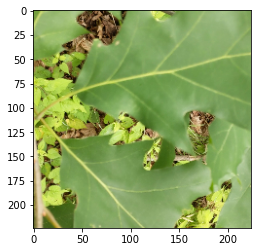

In [14]:
# show sample of processed image
plt.imshow(image)

In [15]:
# credit to DataCamp, Naive Bees project for ideas on augmentations
# crop to square, resize to (224, 224, 3)
# flip and rotate

def color_224_normal(path, tree, overwrite=False):
    # picture file to numpy array
    image = plt.imread(path)

    # create paths to save files to
    c_path = root + "augmentations/{}/c_{}".format(tree+'_color', path.stem)
    c_rot_path = root +"augmentations/{}/c_rot_{}".format(tree+'_color', path.stem)
    c_flip_path = root +"augmentations/{}/c_flip_{}".format(tree+'_color', path.stem)

    # crop to square
    image = square_image(image)
    # resize raw image to reduce pixels, keep 3 channels
    image = resize(image, (224,224,3), anti_aliasing=False)
    c_rotate = rotate(image, 90)  # rotate CW 90 degrees
    c_fliplr = np.fliplr(image) # flip image        

        # save images to specific tree folder in augmentations folder
    if not os.path.exists(c_path):
        np.save(c_path, image, allow_pickle=False)
        
    if not os.path.exists(c_rot_path):     
        np.save(c_rot_path, c_rotate, allow_pickle=False)
        
    if not os.path.exists(c_flip_path):        
        np.save(c_flip_path, c_fliplr, allow_pickle=False)
    else:
        print('.')

In [16]:
# process raw frames to make augmentations
# loop through folders
# run color_224_normal function on each raw frame up to limit

process_images = True
limit = np.inf # limit how many raw images to process for each tree type
folders = os.listdir(root + 'raw_frames')
if process_images: # stop if processing is unnecessary
    # loop through raw images, augment images 3 times, save in new directories
    for t in range(len(folders)):
        count = 0
        path = root + 'raw_frames/'+folders[t]
        photos = os.listdir(path)   # make list of image files in each tree directory
        for photo in photos:      # loop through each photo, making augmentations
            if count == limit:
                break
            color_224_normal(Path(path +'/'+ photo), folders[t], overwrite=False)
            count += 1
            if count%250 == 0:
                print(count) # show progress of processing

In [18]:
folders = os.listdir('augmentations/')
aug_image = os.listdir('augmentations/' + folders[0])[10]

In [19]:
path = 'augmentations/'+folders[0]+'/'+ aug_image
image = np.load(path, allow_pickle=False)
print(aug_image)

c_flip_maple_5_390.npy


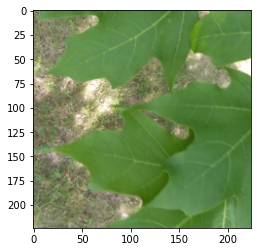

In [20]:
# show example augmentations
plt.imshow(image)

## 1.6 Chunking Data<a id='1.6_Chunking'></a>

In [21]:
# rather than making one large X with all numpy array
# make smaller X and y chunks for less intensive model training

folders = os.listdir('augmentations/')
num_samples = 50  # number of samples to take from each tree type
chunk_size = 10    # number of numpy arrays in a chunk
chunk_num = num_samples*len(folders)//chunk_size
chunk_list = list(range(chunk_num))
rng = np.random.default_rng()
destination = 'image_arrays/'

start = True
X = None
y = None
# make array of random non-repeating numbers
for t in range(len(folders)):
    total_i = []
    if 'maple' in folders[t]:
        tree = 'maple'
        label = 1
        
    else:
        tree = 'oak'
        label = 0
    np_dir = 'augmentations/'+folders[t]
    images = os.listdir(np_dir)
    high = len(images)
    rand_array = rng.permutation(high)[0:num_samples] # non-repeating random integers
    count = 0
    for i in rand_array:
        total_i.append(i)
        file = images[i] # random selection of image from folder
        path = np_dir + '/' + file
        array_i = np.load(path, allow_pickle=False) # take numpy array files from bw_augmentations
    
        
        if start:
            y = np.array([label])
            X = np.array([array_i])
            start=False
            count += 1
        else:
            y = np.append(y,[label]) # for every file from maple or oak add 1 or 0 to y labels
            X = np.append(X,[array_i], axis=0) # add to X - numpy array of images in one file
            count += 1
        if count == chunk_size: # when chunk size is reached, save chunk
            print(X.shape, y.shape)
            print(count)
            chunk = chunk_list.pop(0)
            np.save(destination + 'X_color/' + 'X'+str(chunk)+'_color', X, allow_pickle=False)
            np.save(destination + 'y_color/' + 'y'+str(chunk)+'_color', y, allow_pickle=False)
            start = True
            X = None
            y = None
            count = 0
    print(len(set(total_i)))

(10, 224, 224, 3) (10,)
10
(10, 224, 224, 3) (10,)
10
(10, 224, 224, 3) (10,)
10
(10, 224, 224, 3) (10,)
10
(10, 224, 224, 3) (10,)
10
50
(10, 224, 224, 3) (10,)
10
(10, 224, 224, 3) (10,)
10
(10, 224, 224, 3) (10,)
10
(10, 224, 224, 3) (10,)
10
(10, 224, 224, 3) (10,)
10
50


In [22]:
# import images as numpy array = X
X = np.load(destination + 'X_color/' + 'X6_color.npy', allow_pickle=False)
# import labels as numpy vector = y
y = np.load(destination + 'y_color/' + 'y6_color.npy', allow_pickle=False)
# oak = 0; maple = 1

In [23]:
X.shape, y.shape

((10, 224, 224, 3), (10,))

## 1.7 Create Evaluation Set<a id='1.7_eval_set'></a>

Create dataset that will not be use in training rather evaluation only.

In [24]:
root = 'holdout_set/'

In [25]:
# show videos in holdout_set directory
os.listdir(root + 'videos')

['maple_7.mp4', 'oak_2.mp4']

In [26]:
# extract frames from videos as above

videos = os.listdir(root + 'videos')
process_videos = True # stop cell below from running if not needed
if process_videos:
    for video in videos: # loop through each video
        if 'maple' in video: # put frame in the correct folder (by tree)
            folder = 'maple'
        else:
            folder = 'oak'
        video_path = root + 'videos/' + video  # path of video to extract from
        frames_dir = root + 'raw_frames/' + folder  # path of folder to put frames

        # run extract_frames on each video
        extract_frames(video_path, frames_dir, overwrite=False, start=-1, end=-1, every=30)
   

In [27]:
# process raw frames to make augmentations as above

process_images = True
limit = np.inf # limit how many raw images to process for each tree type
folders = os.listdir(root + 'raw_frames')
if process_images: # stop if processing is unnecessary
    # loop through raw images, augment images 3 times, save in new directories
    for t in range(len(folders)):
        count = 0
        path = root + 'raw_frames/'+folders[t]
        photos = os.listdir(path)   # make list of image files in each tree directory
        for photo in photos:      # loop through each photo, making augmentations
            if count == limit:
                break
            color_224_normal(Path(path +'/'+ photo), folders[t], overwrite=False)
            count += 1
            if count%250 == 0:
                print(count) # show progress of processing

In [28]:
np_dir = root + 'augmentations/'+'maple_color'
images = os.listdir(np_dir)

In [29]:
maple_npy = images[10]
maple_npy

'c_flip_maple_7_390.npy'

In [30]:
path = np_dir + '/' + maple_npy
array_i = np.load(path, allow_pickle=False)

In [31]:
array_i[0][:5]

array([[0.45984269, 0.51082308, 0.47160739],
       [0.44901961, 0.50774935, 0.42819753],
       [0.32452606, 0.39492047, 0.3412465 ],
       [0.24317227, 0.3019958 , 0.31402311],
       [0.13790891, 0.19673244, 0.20919743]])

In [32]:
images = os.listdir('holdout_set/augmentations/maple_color')

In [33]:
# combine data into X and y chunks as above.

folders = ['maple_color','oak_color']
num_samples = 20
chunk_size = 10
chunk_num = num_samples*len(folders)//chunk_size
chunk_list = list(range(chunk_num))
rng = np.random.default_rng()
evaluation_set = True
if evaluation_set:
    suffix = '_eval'
     
else:
    suffix = '_train'

destination = root + 'image_arrays/'

start = True
X = None
y = None
# make array of random non-repeating numbers
for t in range(len(folders)):
    total_i = []
    if 'maple' in folders[t]:
        tree = 'maple'
        label = 1
        
    else:
        tree = 'oak'
        label = 0
    np_dir = root + 'augmentations/'+folders[t]
    images = os.listdir(np_dir)
    high = len(images)
    rand_array = rng.permutation(high)[0:num_samples] # non-repeating random integers
    count = 0
    for i in rand_array:
        total_i.append(i)
        file = images[i] # random selection of image from folder
        path = np_dir + '/' + file
        array_i = np.load(path, allow_pickle=False) # take numpy array files from bw_augmentations
        if count%100 == 0:
            print(file)
        
        if start:
            y = np.array([label])
            X = np.array([array_i])
            start=False
            count += 1
        else:
            y = np.append(y,[label]) # for every file from maple or oak add 1 or 0 to y labels
            X = np.append(X,[array_i], axis=0) # add to X - numpy array of images in one file
            count += 1
        if count == chunk_size:
            print(X.shape, y.shape)
            print(count)
            chunk = chunk_list.pop(0)
            np.save(destination + 'X_color/'+'X'+str(chunk)+suffix, X, allow_pickle=False)
            np.save(destination + 'y_color/'+'y'+str(chunk)+suffix, y, allow_pickle=False)
            start = True
            X = None
            y = None
            count = 0
    print(len(set(total_i)))

c_rot_maple_7_480.npy
(10, 224, 224, 3) (10,)
10
c_maple_7_510.npy
(10, 224, 224, 3) (10,)
10
20
c_oak_2_750.npy
(10, 224, 224, 3) (10,)
10
c_flip_oak_2_240.npy
(10, 224, 224, 3) (10,)
10
20


## 1.8 Display Example Images<a id='1.8_examples'></a>

In [34]:
def show_image(image, title='Image'):
    plt.imshow(image)
    plt.title(title)
    plt.axis('off')
    plt.show()

In [35]:
# selection of one cropped image and its augmentations
path1 = 'augmentations/maple_color/c_maple_5_30.npy' 
path2 = 'augmentations/maple_color/c_rot_maple_5_30.npy'
path3 = 'augmentations/maple_color/c_flip_maple_5_30.npy'

In [36]:
path1_npy = np.load(path1, allow_pickle = False)
path2_npy = np.load(path2, allow_pickle = False)
path3_npy = np.load(path3, allow_pickle = False)

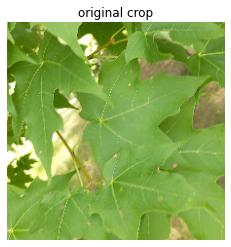

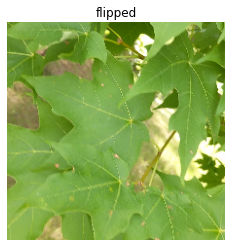

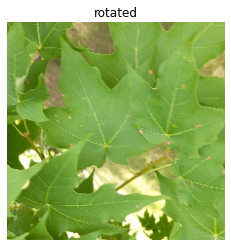

In [37]:
show_image(path1_npy, 'original crop')
show_image(path3_npy, 'flipped')
show_image(path2_npy, 'rotated')